In [2]:
# select a GPU
import os
print(os.getcwd())

import datetime
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!nvidia-smi


/mounts/ud3/contractors/jtaylor/acoustic_scene_classification/LateFusion


Mon Nov  6 10:46:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:04:00.0 Off |                  Off |
| N/A   36C    P0    53W / 250W |  12147MiB / 24451MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:05:00.0 Off |                  Off |
| N/A   

In [3]:
#imports 
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import pickle
import librosa
import soundfile as sound
import tensorflow
import keras
import pickle

print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

print(tensorflow.test.is_built_with_cuda())
print(tensorflow.config.list_physical_devices('GPU'))


Librosa version =  0.10.1
Pysoundfile version =  0.12.1
keras version =  2.8.0
tensorflow version =  2.8.0
True
[]


2023-11-06 10:46:58.007048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-06 10:46:58.007086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
#Task 1a dev validation set
ThisPath = '/work/contractors/jtaylor/acoustic_scene_classification/RFR-CNN-2019/datasets/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [5]:
print(os.getcwd())

#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

/mounts/ud3/contractors/jtaylor/acoustic_scene_classification/LateFusion


In [5]:
# #load wav files and get log-mel spectrograms, deltas, and delta-deltas
# def deltas(X_in):
#     X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
#     X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
#     return X_out

# LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
# for i in range(len(wavpaths)):
#     stereo,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
#     for channel in range(2):
#         LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y=stereo[:,channel], 
#                                        sr=sr,
#                                        n_fft=NumFFTPoints,
#                                        hop_length=HopLength,
#                                        n_mels=NumFreqBins,
#                                        fmin=0.0,
#                                        fmax=sr/2,
#                                        htk=True,
#                                        norm=None)

# LM_val=np.log(LM_val)
# LM_deltas_val = deltas(LM_val)
# LM_deltas_deltas_val = deltas(LM_deltas_val)
# LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

# with open("LMval.pckl", 'wb') as pickle_file:
#     pickle.dump(LM_val, pickle_file, protocol=4)



In [6]:
with open("LMval.pckl", 'rb') as pickle_file:
    LM_val2 = pickle.load(pickle_file)

In [8]:
#load and run the model
best_model = keras.models.load_model('pretrained_models/DCASE_Task1a_development.h5')
# print(best_model.summary())
#y_pred_val = np.argmax(best_model.predict(LM_val2),axis=1)

2023-11-06 10:47:27.829329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
layer_name = 'global_average_pooling2d_2'
intermediate_layer_model = keras.Model(inputs=best_model.input, outputs=best_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(LM_val2)
print(intermediate_output.shape)

2023-11-06 10:47:30.176440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5926763520 exceeds 10% of free system memory.


(4185, 10)


In [10]:
with open('latefusion_embeddings.pckl', 'wb') as f:
    pickle.dump((intermediate_output, y_val_labels), f)

In [10]:
pca3 = PCA(3)
pca3.fit(intermediate_output)
embeddings3 = pca3.transform(intermediate_output)
print(embeddings3)

print(y_val_labels)

[[-1.1551183  -0.6188401   0.12943718]
 [ 1.5477395  -0.07457615 -0.06162208]
 [-0.72257197  1.371216    2.4461575 ]
 ...
 [ 1.4444759   0.01387424 -0.11538217]
 [ 1.6500862   0.22960934  0.07918587]
 [ 1.702523    0.10094858  0.08531552]]
[7 3 4 ... 9 9 9]


[4, 7, 1, 5, 7, 0, 5, 8, 6, 0, 4, 0, 8, 6, 8, 4, 3, 5, 2, 7, 0, 7, 9, 1, 6, 0, 0, 0, 5, 9, 5, 7, 6, 9, 2, 7, 6, 1, 3, 0, 6, 8, 7, 9, 8, 2, 6, 3, 5, 6, 5, 7, 8, 0, 2, 6, 7, 1, 6, 1, 3, 7, 1, 5, 2, 1, 0, 2, 2, 5, 3, 2, 6, 3, 8, 9, 3, 2, 0, 2, 7, 9, 5, 1, 0, 9, 8, 9, 3, 2, 8, 2, 0, 9, 5, 4, 8, 1, 3, 2, 9, 5, 7, 8, 4, 7, 8, 9, 4, 4, 2, 2, 4, 4, 1, 9, 9, 9, 9, 0, 6, 2, 5, 5, 8, 8, 0, 8, 1, 1, 7, 3, 8, 2, 1, 1, 8, 3, 6, 3, 8, 9, 8, 3, 6, 0, 2, 0, 7, 0, 0, 2, 6, 2, 9, 0, 9, 7, 2, 4, 7, 4, 8, 7, 4, 4, 9, 8, 3, 7, 6, 4, 6, 3, 3, 6, 8, 0, 6, 9, 4, 8, 6, 5, 3, 9, 4, 7, 5, 2, 2, 6, 7, 0, 5, 2, 9, 7, 9, 3, 8, 0, 7, 2, 1, 1, 9, 4, 0, 5, 6, 8, 2, 3, 3, 9, 8, 2, 9, 8, 4, 3, 2, 0, 8, 7, 6, 0, 9, 8, 1, 4, 0, 0, 1, 8, 3, 9, 2, 9, 8, 5, 7, 1, 8, 6, 2, 5, 0, 2, 3, 7, 2, 5, 1, 4, 5, 9, 0, 3, 0, 2, 6, 7, 2, 9, 3, 2, 6, 9, 6, 4, 2, 7, 0, 9, 1, 3, 2, 8, 2, 9, 8, 9, 7, 6, 3, 7, 4, 8, 8, 4, 5, 4, 4, 5, 2, 6, 8, 6, 9, 7, 8, 4, 1, 1, 5, 4, 4, 2, 8, 3, 3, 7, 3, 9, 6, 8, 5, 0, 4, 4, 5, 3, 4, 0, 5, 1, 9, 6, 0, 6, 8, 

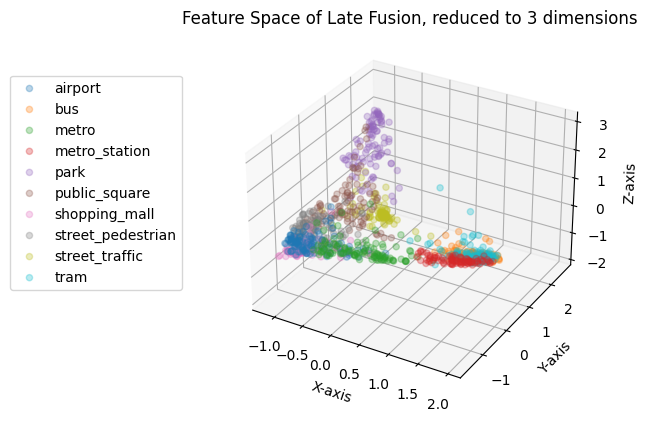

In [13]:
data = embeddings3
ids = y_val_labels

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming your numpy array is named 'data' and the ID list is named 'ids'

# Select a random sample of 100 indices
indices = np.random.choice(len(data), size=1000, replace=False)

# Extract x, y, and z coordinates from the sampled indices
x = data[indices, 0]
y = data[indices, 1]
z = data[indices, 2]

# Extract IDs for the sampled indices
sampled_ids = [ids[i] for i in indices]
print(sampled_ids)


# Map IDs to colors using the colormap
color_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]
colors = [color_list[i] for i in sampled_ids]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot for each unique ID
unique_ids = np.unique(sampled_ids)
for i, unique_id in enumerate(unique_ids):
    # Select data points for the current ID
    id_mask = sampled_ids == unique_id
    x_id = x[id_mask]
    y_id = y[id_mask]
    z_id = z[id_mask]
    

    # Plot the data points with color-coding
    colors_id = [color for color, mask in zip(colors, id_mask) if mask]
    ax.scatter(x_id, y_id, z_id, c=colors_id, label=ClassNames[unique_id], alpha=0.3)

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Add a title to the plot
ax.set_title('Feature Space of Late Fusion, reduced to 3 dimensions')

# Add a legend
ax.legend(bbox_to_anchor=(-.6, .9), loc='upper left')

# Show the plot
plt.show()

In [ ]:
pca2 = PCA(2)
pca2.fit(intermediate_output)
embeddings2 = pca2.transform(intermediate_output)
print(embeddings2)

print(y_val_labels)

[[-1.15512    -0.61883646]
 [ 1.5477394  -0.07458062]
 [-0.72256804  1.3712187 ]
 ...
 [ 1.4444757   0.01387004]
 [ 1.6500866   0.22960465]
 [ 1.7025231   0.10094381]]
[7 3 4 ... 9 9 9]


In [6]:
import matplotlib.patches as mpatches

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

for i in range(10):
    class_data = embeddings2[ids == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], color=color_list[i], alpha=0.2, label=ClassNames[i])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Feature Space of Late Fusion, reduced to 2 dimensions')

# Create custom legend handler to make legend elements fully opaque
def custom_legend_handler(legend, orig_handle, color):
    new_handle = mpatches.Patch(facecolor=color, edgecolor='none', alpha=1)
    return new_handle

# Add legend with custom handler
plt.legend(handler_map={plt.scatter: custom_legend_handler},loc='upper right', bbox_to_anchor=(1.4, 1))

# Show the plot
plt.figure(figsize=(10,6))
plt.show()

NameError: name 'embeddings2' is not defined

overall accuracy:  0.822700119474313
Normalized confusion matrix
[[310   0  27   0   0   0  61  22   1   0]
 [  0 368   0  18   2   0   0   0   0  27]
 [ 13   2 351  18   2   5  28   5   2   9]
 [  0  10  10 353   0   0   0   0   0  60]
 [  0   0   0   0 351  28   0   0   7   0]
 [  0   0   0   1  20 271   2  22  71   0]
 [ 41   0  32   0   0   0 356  12   0   0]
 [ 18   1   8   0   1  17  17 352  15   0]
 [  0   0   0   0   6  15   0   5 376   0]
 [  0  40   0  41   0   0   0   0   0 355]]
per-class accuracy (recall):  [0.73634204 0.88674699 0.80689655 0.81524249 0.90932642 0.7002584
 0.80725624 0.82051282 0.93532338 0.81422018]
per-class precision:  [0.81151832 0.87410926 0.82009346 0.81902552 0.91884817 0.80654762
 0.76724138 0.84210526 0.79661017 0.78713969]
mean per-class recall:  0.82321255223722
mean per-class precision:  0.824323885637634


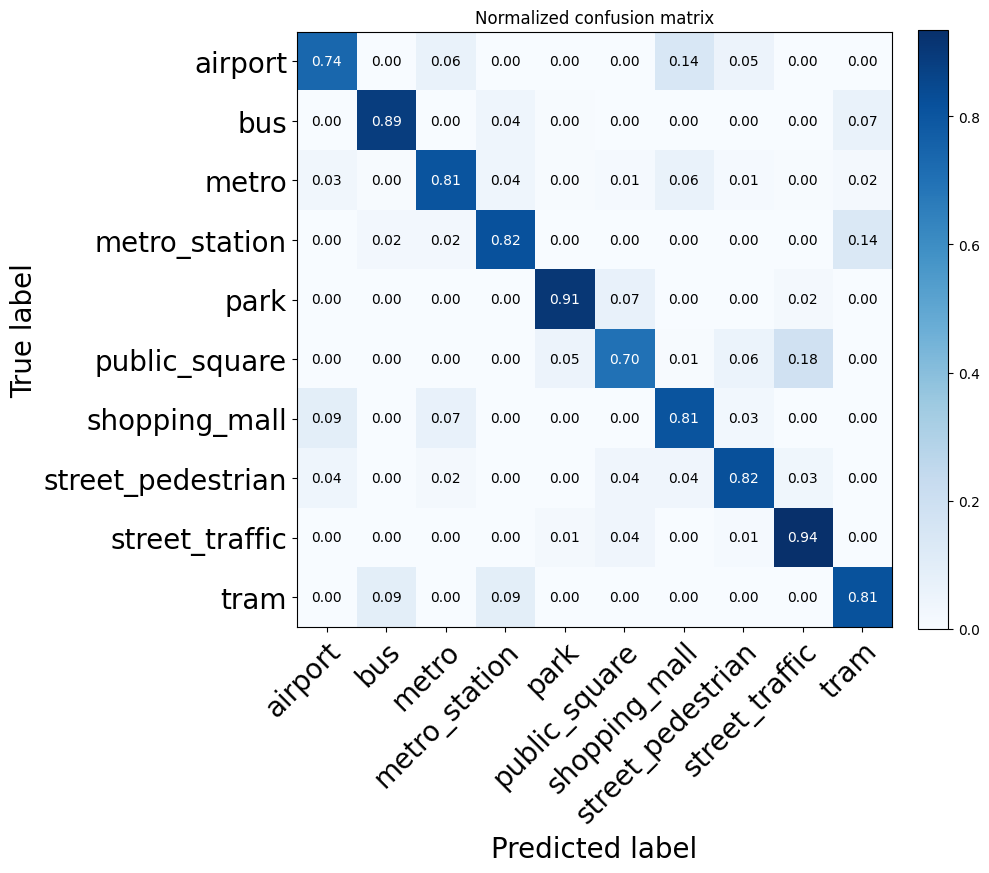

In [17]:
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val2.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
print(conf_matrix)

conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

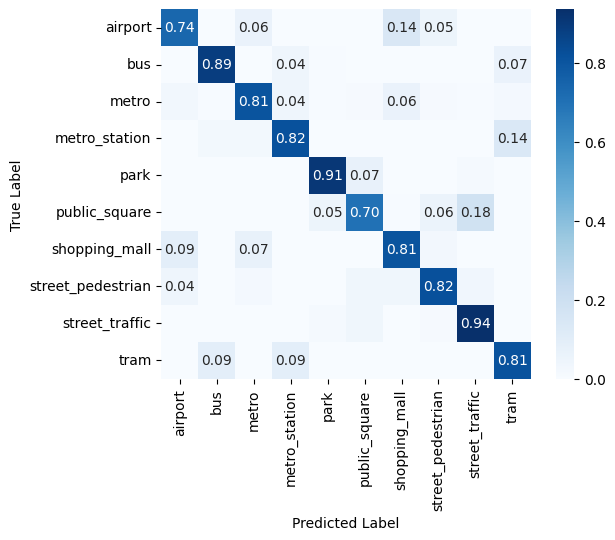

<Figure size 2560x1920 with 0 Axes>

In [21]:
import seaborn as sns

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

annot_kws = {'size': 10}
ax = sns.heatmap(percentages, xticklabels=ClassNames, yticklabels=ClassNames, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

plt.figure(dpi=400)
plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()